<a href="https://colab.research.google.com/github/neyoyoyminoy/MachineLearning/blob/main/Intro2ML_HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework 2**

# **Imports**

In [ ]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
#mounting google drive
from google.colab import drive  #this just has to be given permission once
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Problem 0 (0 points)**  
Load arrays *A*, *y*, and $x_{init}$ from the csv files provided in this assignment. Denote by N and K the rows and columns of A, respectively. Consider the least squares (LS) problem $x_{opt}$ = arg $min_{x∈R^K}$ *L(x)*, where *L(x)* = ∥*Ax − y*∥$_{\substack{2\\2}}$.

In [ ]:
'''def load_csv(path) -> np.ndarray:
  with open(path, 'r', encoding='utf-8') as f:
    data = np.loadtxt(path, delimiter=' ')
  return data

x_init = load_csv('HW2_xinit.csv')
y = load_csv('HW2_y.csv')
A = load_csv('HW2_A.csv')

N, K = A.shape[0], A.shape[1]
N, K '''

folderPath = '/content/drive/MyDrive/MachineLearning/HW2_CSV_DATA' #this is the folder path with google drive

#loading array A from included .csv file
aPath = os.path.join(folderPath, 'HW2_A.csv')
A = pd.read_csv(aPath, header=None, delimiter=' ').values.astype(float) #making sure all values are numeric for later on


#loading array y
yPath = os.path.join(folderPath, 'HW2_y.csv')
y = pd.read_csv(yPath, header=None, delimiter=' ').values.flatten()

#load array xinit
xInitPath = os.path.join(folderPath, 'HW2_xinit.csv')
xInit = pd.read_csv(xInitPath, header=None, delimiter=' ').values.flatten()

N, K = A.shape #N rows and K columns of A

print(f"array A: {A.shape}")
print(f"array y: {y.shape}")
print(f"array xinit: {xInit.shape}")
print(f"{N} rows and {K} columns of A")

array A: (100, 50)
array y: (100,)
array xinit: (50,)
100 rows and 50 columns of A


# **Problem 2: Computations (6 points; 3 points per task)**  
In this problem, perform numerical computations in python using the values provided in the csv file.   
• Compute *H* and *C*.  
• Compute LS solutions *$x_{opt}$* and *$L_{opt}$* by means of SVD.

In [ ]:
A = np.asarray(A, dtype=float) #ran into issues when A wasn't float

H = 2 * A.T @ A #Hessian matrix

print(f"H is \n {H}")

H is 
 [[191.37670132  21.02603409  -6.82631768 ...  -4.91549312  -6.78524379
    8.9469785 ]
 [ 21.02603409 219.34947213  -8.92060565 ...   6.64226026  -0.26495068
   22.82259033]
 [ -6.82631768  -8.92060565 193.49150549 ...   4.38754122  20.95915189
   -2.37970363]
 ...
 [ -4.91549312   6.64226026   4.38754122 ... 260.02628108  20.17156254
   -9.09324095]
 [ -6.78524379  -0.26495068  20.95915189 ...  20.17156254 159.02347483
   15.44256817]
 [  8.9469785   22.82259033  -2.37970363 ...  -9.09324095  15.44256817
  152.18963305]]


In [ ]:
eigenvalues = np.linalg.eigvals(H) #finding eigenvalues from H

C = np.max(eigenvalues) #this just makes sure the C is the maximum eigenvalue

print(f"C is {C}")

C is 565.0372712867082


In [ ]:
U, epsilon, V = np.linalg.svd(A) #U = complex unitary matrix; epsilon = rectangular diagonal matrix; V = conjugate transpose

tolerance = 1e-10 #setting tolerance for small epsilon values
epsilonInv = np.zeros_like(epsilon)
epsilonInv[epsilon > tolerance] = 1.0 / epsilon[epsilon > tolerance]

epsilonInv = np.zeros((A.shape[1], A.shape[0]))
epsilonInv[:A.shape[1], :A.shape[1]] = np.diag(epsilonInv)

pseudoInverseA = V.T @ epsilonInv @ U.T

xopt = pseudoInverseA @ y
Lopt = np.linalg.norm(A @ xopt - y)**2

print(f"xopt is \n{xopt}")
print(f"Lopt is {Lopt}")

xopt is 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
Lopt is 101.15209759146951


# **Problem 3: LS GD with Exact Line Search (ELS) (20 points; 5 points per task)**  
Implement in Python GD for the LS problem. Initialize at the given *$x_{int}$* and run 30 iterations, generating *x1, x2, . . . , x30*. At each iteration *$λ_{n}$*, identify the step size γn by means of the ELS method from the lecture notes.  
• **Plot:** In Fig. 1 of your report, plot *$L_{xn}$* vs iteration index *n = 1, 2, . . . , 30*, for the GD with ELS (blue solid line). In the same figure plot *$L_{opt}$* as a horizontal benchmark (black dashed line).  
• **Discuss** Fig. 1.  
• **Plot:**  In Fig. 2 of your report, plot *$λ_{n}$* vs iteration index *n = 1, 2, . . . , 30*, for the GD with ELS.
In the same figure, plot 1/*C* as a horizontal benchmark (black dashed line).
• **Discuss** Fig. 2.

In [ ]:
lValues = []
xValues = [] #needed to store x and y values to calculate the next gradient
gammaValues = [] #step sizes
x = xInit.copy()

#using this function to calculate the gradient of L(x)
def gradientL(x, A, y):
  return 2 * A.T @ (A @ x - y)

for n in range(30): #30 iterations
    gradient = gradientL(x, A, y)

    denominator = 2 * np.linalg.norm(A @ gradient)**2
    if denominator == 0:
        break
    gammaN = float((gradient.T @ gradient) / denominator)

    gammaValues.append(gammaN) #storing gammaN
    x = x - gammaN * gradient #updating x

    #calculating L(x)
    Lx = np.linalg.norm(A @ x - y)**2
    lValues.append(Lx)
    xValues.append(x.copy()) #storing L(x) to plot later

print(f"step size at each iteration: \n {gammaValues}")

step size at each iteration: 
 [0.00268199544541485, 0.0028806303857862262, 0.0029732719928614922, 0.0030608631223314137, 0.003095021050684799, 0.0031536713996060265, 0.0031695649941656887, 0.0032179339261654903, 0.0032231621400651404, 0.0032617358498508676, 0.0032565778830478697, 0.0032871470593945126, 0.0032754268961327875, 0.0033018469614880053, 0.003287155625712488, 0.003311997928675606, 0.0032962115040286585, 0.003320645104318334, 0.003304512512276373, 0.0033289535158510333, 0.0033126918161971563, 0.0033372178326020376, 0.0033208179618126467, 0.0033453638362797937, 0.0033287311857828957, 0.0033531818714693366, 0.0033362056131410306, 0.0033604455709883843, 0.003343035504541144, 0.003366975627866395]


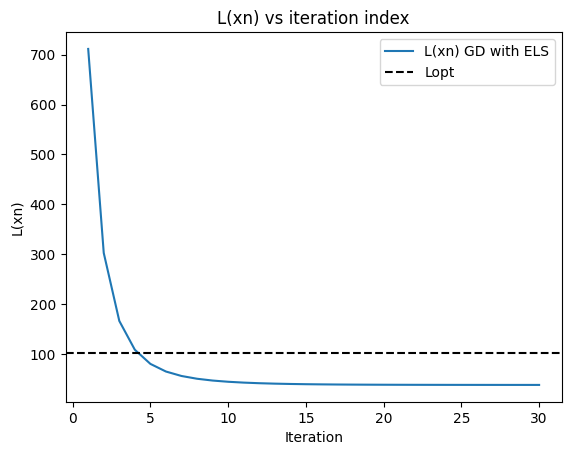

In [ ]:
plt.plot(range(1, 31), lValues, label='L(xn) GD with ELS')
plt.axhline(y=Lopt, linestyle='dashed', c='black', label='Lopt')
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("L(xn)")
plt.title("L(xn) vs iteration index")
plt.show()

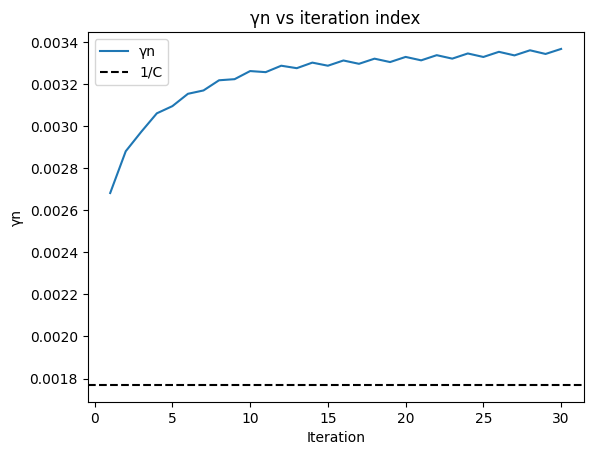

In [ ]:
plt.plot(range(1, 31), gammaValues, label='γn')
plt.axhline(y=1/C, linestyle='dashed', c='black', label='1/C')
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("γn")
plt.title("γn vs iteration index")
plt.show()

# Problem 4:
LS GD with Fixed Step Size (FSS) (10 points; 5 points per task)

Implement in Python GD for the LS problem. Initialize at the given xinit and run 30 iterations, generating
x1, x2, . . . , x30. In all iteration steps, use the same fixed step size γ, set to p×1/C, where C is the Lipschitz
constant of LS and p is a scaling factor.

• Plot: In Fig. 3 of your report, plot L(xn) vs iteration index n = 1, 2, . . . , 30, for the GD with FSS,
for p = 0.1, 0.5, 1, 1.5, 2 (5 curves). In the same figure plot Lopt as a horizontal benchmark (black
dashed line).

• Discuss Fig. 3. How does each value of p affect the convergence?

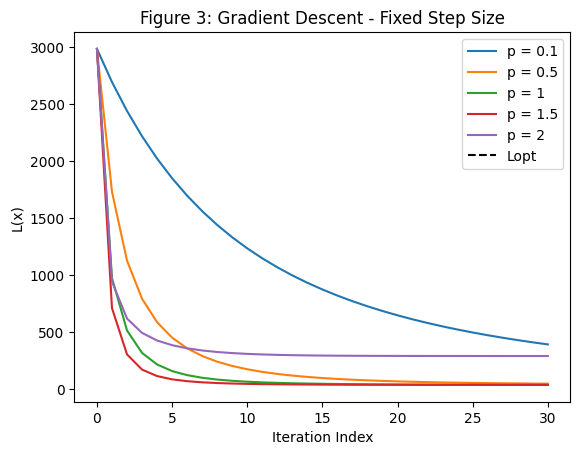

In [ ]:
iterations = 30
p = [0.1, 0.5, 1, 1.5, 2]

def L(x):
  return np.linalg.norm(A @ x - y)**2

Lx_n_fss = {i: [L(xInit)] for i in p}

for pi in p:
  x_fss = xInit.copy()
  𝛾 = pi * (1/C)
  for _ in range(iterations):
    gradient = gradientL(x_fss, A, y)
    x_fss = x_fss - 𝛾 * gradient
    Lx_n_fss[pi].append(L(x_fss))

for fss in Lx_n_fss:
  plt.plot(Lx_n_fss[fss], label=f'p = {fss}')

plt.legend()
plt.ylabel("L(x)")
plt.xlabel("Iteration Index")
plt.title("Figure 3: Gradient Descent - Fixed Step Size")
plt.show()

The value of p has a great affect on speed (number of iterations it takes) and quality of convergence. Lower p values (p < 1) cause the convergence to slow down, sometimes never converging, but always approach a global minima (the lowest possible L(x)). Higher p (p >= 1) values cause convergence in fewer iterations but often get stuck in a local minima (see p=2)

### Problem 5: LS GD with Backtracking Line Search (60 points; 5 points per task)
Implement in Python GD for the LS problem. Initialize at the given xinit and run 30 iterations, generating
x1, x2, . . . , x30. At each iteration n, identify the step size γn by means of the BLS method from the class
notes, with parameters η and c.

• Plot: In Fig. 4 of your report, plot L(xn) vs iteration index n = 1, 2, . . . , 30, for the GD with
BLS, for c = 0.1 and η = 0.1, 0.2, 0.5, 0.9 (4 curves). In the same figure plot Lopt as a horizontal
benchmark (black dashed line).

• Discuss Fig. 4. How does convergence vary across η?

• Plot: In Fig. 5 of your report, plot runtime bars versus η (for fixed c = 0.1). That is, each bar
corresponds to the runtime of GD from initialization to termination, for a given value of η.

• Discuss Fig. 5. How does η affect runtime?

• Plot: In Fig. 6 of your report, plot γn vs iteration index n = 1, 2, . . . , 30, for the GD with BLS, for
c = 0.1 and η = 0.1, 0.2, 0.5, 0.9 (4 curves). In the same figure, plot 1/C as a horizontal benchmark
(black dashed line).

• Discuss Fig. 6.

• Plot: In Fig. 7 of your report, plot L(xn) vs iteration index n = 1, 2, . . . , 30, for the GD with BLS,
for η = 0.5 and c = 0.01, 0.1 (2 curves). In the same figure plot Lopt as a horizontal benchmark
(black dashed line).

• Discuss Fig. 7. How does convergence vary across c?

• Plot: In Fig. 8 of your report, plot runtime bars versus c (for fixed η = 0.5). That is, each bar
corresponds to the runtime of GD from initialization to termination, for a given value of c.

• Discuss Fig. 8. How does c affect runtime?

• Plot: In Fig. 9 of your report, plot γn vs iteration index n = 1, 2, . . . , 30, for the GD with BLS,
for η = 0.5 and c = 0.01, 0.1 (2 curves). In the same figure, plot 1/C as a horizontal benchmark
(black dashed line).

• Discuss Fig. 9.

In [ ]:
import time

iterations = 30
c = 0.1
η = [0.1, 0.2, 0.5, 0.9]

def L(x):
  return np.linalg.norm(A @ x - y)**2

Lx_n = {n: [L(xInit)] for n in η}
rt_n = {n: 0 for n in η}
𝛾_n = {n: [] for n in η}

for 𝛽 in η:
  x_bls = xInit.copy()
  tic = time.time()

  for _ in range(iterations):
    𝛾 = 5.0
    x_prev = x_bls
    gradient = gradientL(x_prev, A, y)

    while True:
      x_bls = x_prev - 𝛾 * gradient
      if L(x_prev) - L(x_bls) <= c * 𝛾 * float(np.linalg.norm(gradient))**2:  # Armijo Condition
        𝛾 *= 𝛽
      else:
        break

    Lx_n[𝛽].append(L(x_bls))
    𝛾_n[𝛽].append(𝛾)

  toc = time.time()
  rt_n[𝛽] = toc - tic


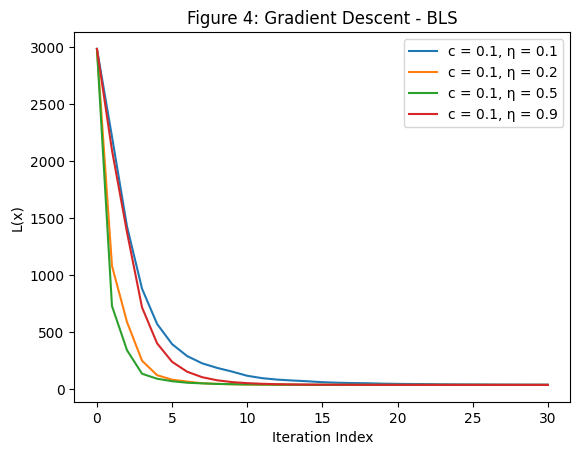

In [ ]:
for ηi in Lx_n:
  plt.plot(Lx_n[ηi], label=f'c = 0.1, η = {ηi}')
plt.legend()
plt.ylabel("L(x)")
plt.xlabel("Iteration Index")
plt.title("Figure 4: Gradient Descent - BLS")
plt.show()

 This shows that conv

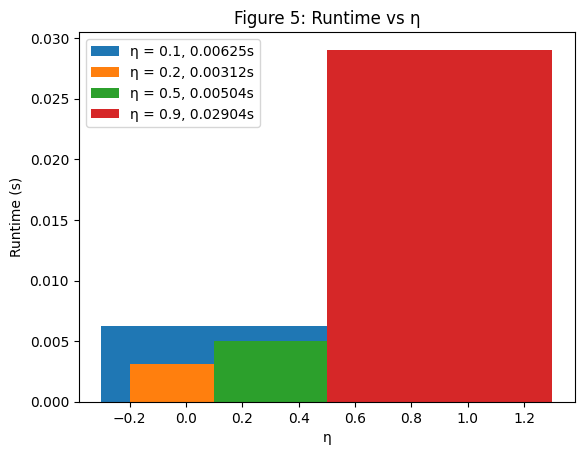

In [ ]:
for ni in η:
  plt.bar(ni, rt_n[ni], label=f'η = {ni}, {round(rt_n[ni], 5)}s')
plt.legend()
plt.ylabel("Runtime (s)")
plt.xlabel("η")
plt.title("Figure 5: Runtime vs η")
plt.show()

Discuss

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 120574 (\N{MATHEMATICAL ITALIC SMALL GAMMA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


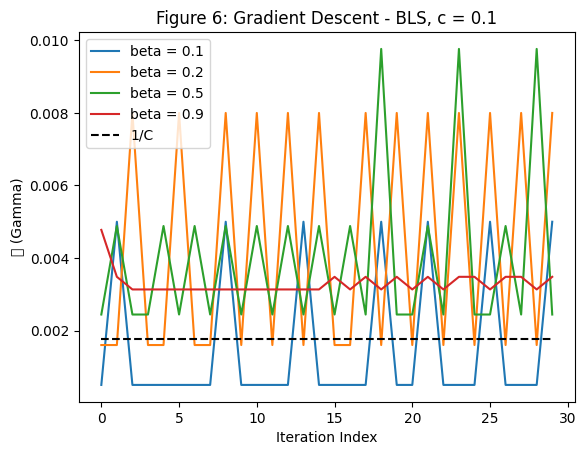

In [ ]:
for y in 𝛾_n:
  plt.plot(𝛾_n[y], label=f'beta = {y}')
plt.plot(range(30), [(1/C)]*30, label='1/C', linestyle='dashed', c='black')
plt.legend()
plt.ylabel("𝛾 (Gamma)")
plt.xlabel("Iteration Index")
plt.title("Figure 6: Gradient Descent - BLS, c = 0.1")
plt.show()

Figure 6 shows that for all 𝛽 the 𝛾 values chosen by the BLS method are always near 1/C. For each value of beta the values gamma take oscillates between a few of values between each iteration. Higher values of beta result in a smaller range of values taken by gamma, making it less flexible.

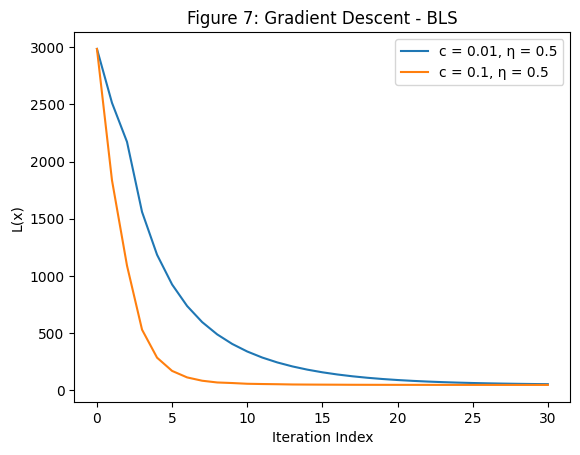

In [ ]:
iterations = 30
c = [0.01, 0.1]
η = 0.5

def L(x):
  return np.linalg.norm(A @ x - y)**2

Lx_n = {i: [L(xInit)] for i in c}
rt_n = {i: 0 for i in c}
𝛾_n = {i: [] for i in c}

for ci in c:
  x_bls = xInit.copy()

  tic = time.time()
  for _ in range(iterations):
    𝛾 = 1.0
    x_prev = x_bls
    gradient = gradientL(x_prev, A, y)

    while True:
      x_bls = x_prev - 𝛾 * gradient
      if L(x_prev) - L(x_bls) <= ci * 𝛾 * float(np.linalg.norm(gradient))**2:  # Armijo Condition
        𝛾 *= 𝛽
      else:
        break

    Lx_n[ci].append(L(x_bls))
    𝛾_n[ci].append(𝛾)

  toc = time.time()
  rt_n[ci] = toc - tic

for ci in Lx_n:
  plt.plot(Lx_n[ci], label=f'c = {ci}, η = 0.5')
plt.plot(Lopt, linestyle="dashed", c="black")
plt.legend()
plt.ylabel("L(x)")
plt.xlabel("Iteration Index")
plt.title("Figure 7: Gradient Descent - BLS")
plt.show()

Convergence happens in fewer iterations as c increases.

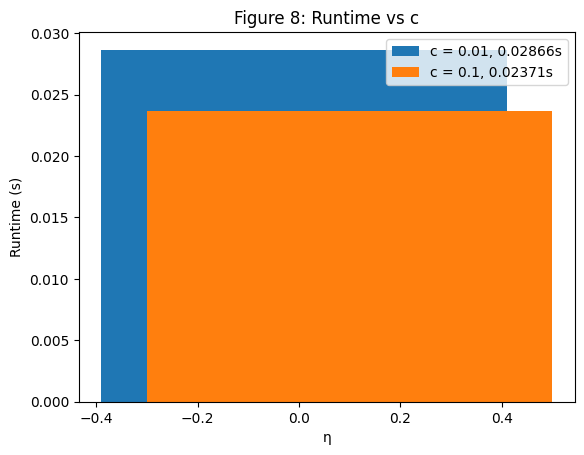

In [ ]:
for ni in c:
  plt.bar(ni, rt_n[ni], label=f'c = {ni}, {round(rt_n[ni], 5)}s')
plt.legend()
plt.ylabel("Runtime (s)")
plt.xlabel("η")
plt.title("Figure 8: Runtime vs c")
plt.show()

Runtime increases as c decreases.

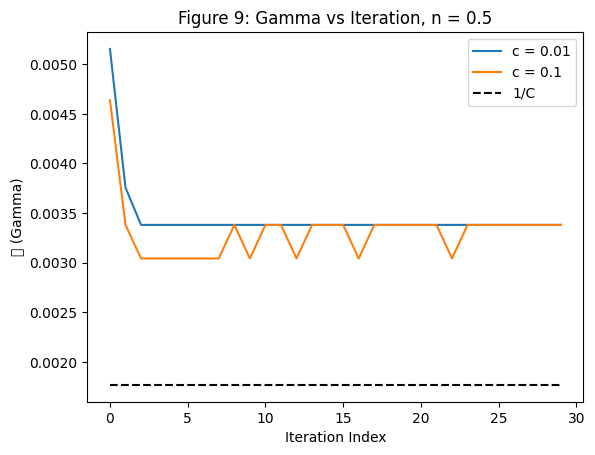

In [ ]:
for y in 𝛾_n:
  plt.plot(𝛾_n[y], label=f'c = {y}')
plt.plot(range(30), [(1/C)]*30, label='1/C', linestyle='dashed', c='black')
plt.legend()
plt.ylabel("𝛾 (Gamma)")
plt.xlabel("Iteration Index")
plt.title("Figure 9: Gamma vs Iteration, n = 0.5")
plt.show()

The gamma value for c = 0.01 decreases to a stationary point and stays there for all iterations after that. The gamma value for c = 0.1 goes closer to 1/C but also takes the gamma calculated from c = 0.01. It oscillates between the to values everytime backtracking happens.

# **Citations**  
Least Squares: https://numpy.org/doc/2.0/reference/generated/numpy.linalg.lstsq.html  
Gradient Descent: https://www.geeksforgeeks.org/machine-learning/how-to-implement-a-gradient-descent-in-python-to-find-a-local-minimum/